In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count, mean, lit
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml import Pipeline

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Healthcare Dataset Preprocessing") \
    .getOrCreate()

# Load the dataset - use inferSchema to detect column types
df = spark.read.csv("/content/diabetic_data.csv", header=True, inferSchema=True)

# Cloumns in the dataset.
print("Dataset Schema:")
df.printSchema()
print("First few rows:")
df.show(5)

# Replace '?' with None (NULL) in all columns
df = df.select([when(col(c) == "?", None).otherwise(col(c)).alias(c) for c in df.columns])

# Get actual column names from the dataset
actual_columns = df.columns
print("Actual columns in the dataset:", actual_columns)

# Check for missing values across all columns
print("\nMissing value analysis:")
for column in actual_columns:
    null_count = df.filter(col(column).isNull()).count()
    print(f"Column {column}: {null_count} nulls")

potential_numeric_cols = []
for column in actual_columns:
    # Check if the column appears to be numeric and not an ID column
    if df.select(column).dtypes[0][1] in ('int', 'double', 'float') and not ('id' in column.lower() or 'nbr' in column.lower()):
        potential_numeric_cols.append(column)

print("\nPotential numeric columns for zero handling:", potential_numeric_cols)

# Function to count zeros in identified numeric columns
def count_zeros(df, columns):
    for col_name in columns:
        try:
            zero_count = df.filter(col(col_name) == 0).count()
            print(f"Column {col_name}: {zero_count} zeros")
        except:
            print(f"Error checking zeros for column {col_name}")

count_zeros(df, potential_numeric_cols)

implausible_zero_cols = []  # Fill this with columns that shouldn't have zeros

# Replace zeros with nulls in appropriate columns
df_cleaned = df
for column in implausible_zero_cols:
    if column in actual_columns:  # Check if column exists
        df_cleaned = df_cleaned.withColumn(
            column,
            when(col(column) == 0, None).otherwise(col(column))
        )

# Impute missing values with mean for numeric columns
for column in potential_numeric_cols:
    try:
        # Calculate mean excluding null values
        mean_value = df_cleaned.filter(col(column).isNotNull()).select(mean(col(column))).collect()[0][0]
        if mean_value is not None:  # Check if mean could be calculated
            df_cleaned = df_cleaned.withColumn(
                column,
                when(col(column).isNull(), mean_value).otherwise(col(column))
            )
            print(f"Imputed {column} with mean value: {mean_value}")
    except:
        print(f"Could not impute column {column}")

# Handle categorical columns (if any)
# For simplicity, we'll identify likely categorical columns
categorical_cols = []
for column in actual_columns:
    # Check if string type or has few distinct values
    if df.select(column).dtypes[0][1] == 'string' or column in ['gender', 'race']:
        categorical_cols.append(column)

print("\nPotential categorical columns:", categorical_cols)


for column in categorical_cols:
    if column in actual_columns:
        # Get most frequent value
        most_frequent = df_cleaned.groupBy(column).count().orderBy("count", ascending=False).first()
        if most_frequent and most_frequent[0] is not None:  # Check if we found a most frequent value
            most_frequent_value = most_frequent[0]
            df_cleaned = df_cleaned.withColumn(
                column,
                when(col(column).isNull(), most_frequent_value).otherwise(col(column))
            )
            print(f"Imputed {column} with most frequent value: {most_frequent_value}")

# Ensure all numeric columns are Double type
for column in potential_numeric_cols:
    if column in actual_columns:
        df_cleaned = df_cleaned.withColumn(column, col(column).cast(DoubleType()))

excluded_cols = ['encounter_id', 'patient_nbr']  # Add your outcome column here too
feature_cols = [c for c in potential_numeric_cols if c not in excluded_cols]

print("\nSelected feature columns:", feature_cols)

# Create VectorAssembler only if we have features to assemble
if feature_cols:
    # Create a VectorAssembler to combine feature columns into a vector column
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

    # Create a standard scaler to normalize the features
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features",
                            withStd=True, withMean=True)

    # Define the pipeline
    pipeline = Pipeline(stages=[assembler, scaler])

    # Apply the pipeline to the data
    try:
        pipeline_model = pipeline.fit(df_cleaned)
        df_processed = pipeline_model.transform(df_cleaned)

        # Show the processed data
        print("\nProcessed DataFrame (sample):")
        df_processed.select(feature_cols[:2] + ["features", "scaled_features"]).show(5, truncate=True)

        # Split data into training and testing sets (80% training, 20% testing)
        train_data, test_data = df_processed.randomSplit([0.8, 0.2], seed=42)

        print("Training data count:", train_data.count())
        print("Testing data count:", test_data.count())

        # Save the processed datasets
        train_data.write.mode("overwrite").parquet("healthcare_train.parquet")
        test_data.write.mode("overwrite").parquet("healthcare_test.parquet")

        print("Preprocessing complete! Data saved as parquet files.")
    except Exception as e:
        print(f"Error in pipeline processing: {e}")
        print("Saving cleaned data without feature engineering")
        df_cleaned.write.mode("overwrite").parquet("healthcare_cleaned.parquet")
else:
    print("No feature columns identified. Saving cleaned data without feature engineering.")
    df_cleaned.write.mode("overwrite").parquet("healthcare_cleaned.parquet")

Dataset Schema:
root
 |-- encounter_id: integer (nullable = true)
 |-- patient_nbr: integer (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- admission_type_id: integer (nullable = true)
 |-- discharge_disposition_id: integer (nullable = true)
 |-- admission_source_id: integer (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- payer_code: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: integer (null

In [ ]:
#This one is AI Generated so idk wtf it is.

from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Healthcare Model Training") \
    .getOrCreate()

# Load preprocessed data
try:
    train_data = spark.read.parquet("healthcare_train.parquet")
    test_data = spark.read.parquet("healthcare_test.parquet")
    print("Successfully loaded preprocessed data.")
except Exception as e:
    print(f"Error loading preprocessed data: {e}")
    print("Trying to load the cleaned data instead...")
    try:
        train_data = spark.read.parquet("healthcare_cleaned.parquet")
        print("Successfully loaded cleaned data.")
    except:
        print("Could not find preprocessed or cleaned data. Please check file paths.")
        exit(1)

# Display available columns and their data types
print("\nAvailable columns and data types:")
for field in train_data.schema.fields:
    print(f"{field.name}: {field.dataType}")

# Guide for identifying the target column
print("\n" + "="*80)
print("TARGET COLUMN IDENTIFICATION GUIDE")
print("="*80)
print("Look for a column that represents the outcome you want to predict.")
print("Common names for target columns include:")
print("- 'outcome', 'Outcome', 'target', 'label', 'readmitted', 'diagnosis'")
print("- 'diabetes', 'diabetic', 'has_disease', 'positive'")
print("The target column is typically binary (0/1) for classification tasks.")
print("\nLet's analyze potential target columns...")

# List potential binary/categorical columns that could be target columns
potential_target_columns = []
categorical_columns = []

for field in train_data.schema.fields:
    # Check if field is likely a categorical or binary column
    if "string" in str(field.dataType).lower() or "int" in str(field.dataType).lower():
        # Get distinct count - low count suggests categorical/target variable
        distinct_count = train_data.select(field.name).distinct().count()

        if distinct_count <= 10:  # Arbitrary threshold for categorical variables
            categorical_columns.append((field.name, distinct_count))
            # If column has 2-5 distinct values, it might be a target
            if 2 <= distinct_count <= 5:
                potential_target_columns.append(field.name)

# Print categorical columns
print("\nCategorical columns (candidates for target):")
for col_name, distinct_count in categorical_columns:
    print(f"- {col_name}: {distinct_count} distinct values")
    # Show distribution for potential targets
    if col_name in potential_target_columns:
        print("  Distribution:")
        train_data.groupBy(col_name).count().orderBy("count", ascending=False).show(truncate=False)

# If no potential targets found, look for columns with suggestive names
if not potential_target_columns:
    print("\nNo obvious target columns identified. Looking for columns with suggestive names...")
    target_keywords = ["outcome", "target", "label", "diabetic", "diabetes", "readmitted",
                       "diagnosis", "disease", "positive", "result"]

    for field in train_data.schema.fields:
        for keyword in target_keywords:
            if keyword.lower() in field.name.lower():
                print(f"Potential target based on name: {field.name}")
                # Show distribution
                print("  Distribution:")
                train_data.groupBy(field.name).count().orderBy("count", ascending=False).show(truncate=False)

# Interactive target column selection
print("\n" + "="*80)
print("NEXT STEPS:")
print("="*80)
print("1. Based on the analysis above, identify your target column")
print("2. Modify the 'target_col' variable in the script below to match your target column")
print("3. Run the rest of the script to train and evaluate models")
print("\nExample code for model training (update target_col):")
print('''
# Set your target column here
target_col = "your_target_column_name"  # Replace with your actual target column

# Check if target column exists
if target_col not in train_data.columns:
    print(f"Error: Target column '{target_col}' not found. Please specify the correct target column.")
    exit(1)

# Print class distribution for target column
print("\\nClass distribution in training data:")
train_data.groupBy(target_col).count().orderBy("count", ascending=False).show()

# Continue with model training...
''')

# The rest of the model training code would follow here
# (The same as in the previous artifact, but not executed until target column is confirmed)
print("\nScript completed. Please update the target column and run the model training part.")

Successfully loaded preprocessed data.

Available columns and data types:
encounter_id: IntegerType()
patient_nbr: IntegerType()
race: StringType()
gender: StringType()
age: StringType()
weight: StringType()
admission_type_id: IntegerType()
discharge_disposition_id: IntegerType()
admission_source_id: IntegerType()
time_in_hospital: DoubleType()
payer_code: StringType()
medical_specialty: StringType()
num_lab_procedures: DoubleType()
num_procedures: DoubleType()
num_medications: DoubleType()
number_outpatient: DoubleType()
number_emergency: DoubleType()
number_inpatient: DoubleType()
diag_1: StringType()
diag_2: StringType()
diag_3: StringType()
number_diagnoses: DoubleType()
max_glu_serum: StringType()
A1Cresult: StringType()
metformin: StringType()
repaglinide: StringType()
nateglinide: StringType()
chlorpropamide: StringType()
glimepiride: StringType()
acetohexamide: StringType()
glipizide: StringType()
glyburide: StringType()
tolbutamide: StringType()
pioglitazone: StringType()
rosi

In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("DiabetesModel").getOrCreate()

# Load training and testing data
train_data = spark.read.parquet("/content/healthcare_train.parquet")
test_data = spark.read.parquet("/content/healthcare_test.parquet")

# Show schema
train_data.printSchema()


root
 |-- encounter_id: integer (nullable = true)
 |-- patient_nbr: integer (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- admission_type_id: integer (nullable = true)
 |-- discharge_disposition_id: integer (nullable = true)
 |-- admission_source_id: integer (nullable = true)
 |-- time_in_hospital: double (nullable = true)
 |-- payer_code: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: double (nullable = true)
 |-- num_procedures: double (nullable = true)
 |-- num_medications: double (nullable = true)
 |-- number_outpatient: double (nullable = true)
 |-- number_emergency: double (nullable = true)
 |-- number_inpatient: double (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: double (nullable = true)
 |-- max_gl

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the model
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="time_in_hospital", numTrees=50)

# Train the model
model = rf.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate Model Accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="time_in_hospital", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)

print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 78.28%


In [ ]:
model.write().overwrite().save("diabetes_rf_model")

In [ ]:
from pyspark.ml.classification import RandomForestClassificationModel

# Load the saved classification model
loaded_model = RandomForestClassificationModel.load("diabetes_rf_model")

# Make predictions using the loaded model
loaded_predictions = loaded_model.transform(test_data)
loaded_predictions.select("time_in_hospital", "prediction").show(5)


+----------------+----------+
|time_in_hospital|prediction|
+----------------+----------+
|             1.0|       1.0|
|             7.0|       6.0|
|             4.0|       4.0|
|             4.0|       4.0|
|             2.0|       2.0|
+----------------+----------+
only showing top 5 rows



Question3

In [ ]:
#Question 3:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("PatientLengthOfStay") \
    .getOrCreate()


In [ ]:
train_df = spark.read.parquet("healthcare_train.parquet")
test_df = spark.read.parquet("healthcare_test.parquet")

In [ ]:
# Drop the existing "features" column if it already exists
if "features" in train_df.columns:
    train_df = train_df.drop("features")
if "features" in test_df.columns:
    test_df = test_df.drop("features")

# Apply VectorAssembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

train_df = assembler.transform(train_df)
test_df = assembler.transform(test_df)


In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Define the model
rf = RandomForestRegressor(featuresCol="features", labelCol="time_in_hospital")

# Train the model
rf_model = rf.fit(train_df)

# Make predictions
predictions = rf_model.transform(test_df)


In [ ]:
from pyspark.sql.functions import abs, col, avg
test_results = model.transform(test_df)
# Compute MAPE
mape = test_results.withColumn("abs_percentage_error",
                               abs(col("prediction") - col("time_in_hospital")) / col("time_in_hospital")) \
                    .agg(avg("abs_percentage_error") * 100) \
                    .collect()[0][0]

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Percentage Error (MAPE): 8.35%


In [ ]:
rf_model.write().overwrite().save("diabetes_rf_model")

2. Resource Utilization:

In [ ]:
from pyspark.sql.functions import col, avg

resource_utilization = train_df.groupBy("time_in_hospital").agg(
    avg("num_lab_procedures").alias("avg_lab_procedures"),
    avg("num_procedures").alias("avg_procedures"),
    avg("num_medications").alias("avg_medications")
)

resource_utilization.show()

+----------------+------------------+------------------+------------------+
|time_in_hospital|avg_lab_procedures|    avg_procedures|   avg_medications|
+----------------+------------------+------------------+------------------+
|             8.0| 51.24499012136607|1.8498447643240192| 20.99379057296077|
|             7.0|50.386208368915455| 1.640264730999146| 20.01131511528608|
|             1.0| 32.80728470923501|1.2543414373497195|11.095467094131267|
|             4.0| 43.73697002430462|1.1817445314609776|15.963813124493655|
|            11.0| 54.03791469194313| 2.211238997968856|23.660121868652674|
|            14.0|55.760998810939356|2.4066587395957195|25.478002378121285|
|             3.0| 40.44881279503981|1.0818008877615726|14.374691749453957|
|             2.0| 37.68183791606368|  1.01534008683068|12.512445730824892|
|            10.0|53.406417112299465|2.0679144385026738| 23.05133689839572|
|            13.0| 55.29320987654321|2.3034979423868314|24.623456790123456|
|           

3.Treatment Effectiveness Analysis

In [ ]:
from pyspark.sql.functions import corr

# Correlation between medications and length of stay
correlation = train_df.select(corr("num_medications", "time_in_hospital")).collect()[0][0]
print(f"Correlation between medications and hospital stay: {correlation}")

Correlation between medications and hospital stay: 0.46438230961580346


4. Cost Analysis per Diagnosis (RDD vs DataFrame vs SQL)

In [ ]:
!pip install psutil matplotlib
import psutil
import matplotlib.pyplot as plt
import time

In [ ]:
import threading

def monitor_resources(duration=10, interval=0.5):
    cpu_usage = []
    memory_usage = []
    timestamps = []

    start_time = time.time()

    while time.time() - start_time < duration:
        cpu_usage.append(psutil.cpu_percent())
        memory_usage.append(psutil.virtual_memory().percent)
        timestamps.append(time.time() - start_time)
        time.sleep(interval)

    return timestamps, cpu_usage, memory_usage


In [ ]:
def plot_metrics(timestamps, cpu_usage, memory_usage, title="System Resource Utilization"):
    plt.figure(figsize=(10, 5))

    plt.plot(timestamps, cpu_usage, label="CPU Usage (%)", color="r")
    plt.plot(timestamps, memory_usage, label="Memory Usage (%)", color="b")

    plt.xlabel("Time (seconds)")
    plt.ylabel("Usage (%)")
    plt.title(title)
    plt.legend()
    plt.grid()

    plt.show()


Using RDD

In [ ]:
from pyspark.sql import Row

# Convert a DataFrame into an RDD
rdd_avg_cost = train_df.select("time_in_hospital", "num_medications").rdd

# Convert RDD to DataFrame
rdd_avg_cost_df = rdd_avg_cost.map(lambda x: Row(time_in_hospital=x[0], avg_num_medications=x[1])).toDF()

# Show the table
rdd_avg_cost_df.show(10)


+----------------+-------------------+
|time_in_hospital|avg_num_medications|
+----------------+-------------------+
|            13.0|               28.0|
|            12.0|               18.0|
|             9.0|               17.0|
|             3.0|               16.0|
|             7.0|               11.0|
|            10.0|               31.0|
|             1.0|                2.0|
|             5.0|               12.0|
|             2.0|               13.0|
|            12.0|               13.0|
+----------------+-------------------+
only showing top 10 rows



Using Dataframe API

+----------------+------------------+
|time_in_hospital|   avg_medications|
+----------------+------------------+
|             8.0| 20.99379057296077|
|             7.0| 20.01131511528608|
|             1.0|11.095467094131267|
|             4.0|15.963813124493655|
|            11.0|23.660121868652674|
|            14.0|25.478002378121285|
|             3.0|14.374691749453957|
|             2.0|12.512445730824892|
|            10.0| 23.05133689839572|
|            13.0|24.623456790123456|
|             6.0|18.677691417231685|
|             5.0|17.492784274695197|
|             9.0| 22.05645496056455|
|            12.0| 24.06643658326143|
+----------------+------------------+



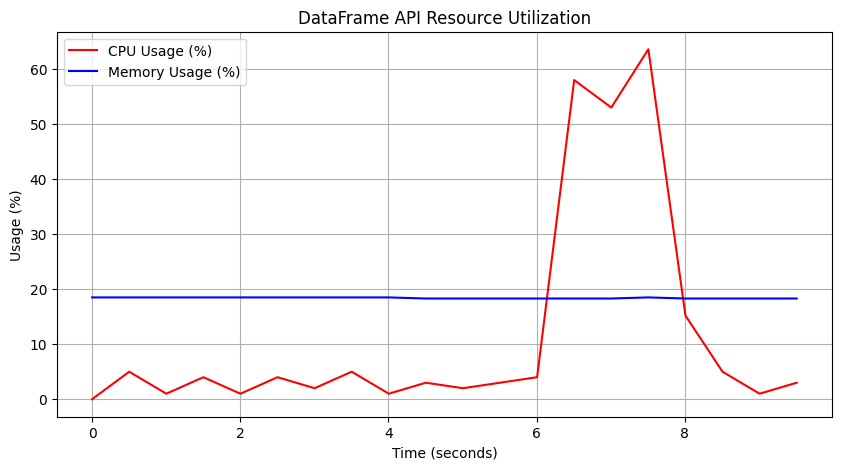

In [ ]:
monitor_thread = threading.Thread(target=monitor_resources, args=(10, 0.5))
monitor_thread.start()

df_avg_cost = train_df.groupBy("time_in_hospital").agg(avg("num_medications").alias("avg_medications"))
df_avg_cost.show()

monitor_thread.join()
timestamps, cpu_usage, memory_usage = monitor_resources(10, 0.5)
plot_metrics(timestamps, cpu_usage, memory_usage, "DataFrame API Resource Utilization")


Using Spark SQL

+----------------+------------------+
|time_in_hospital|   avg_medications|
+----------------+------------------+
|             8.0| 20.99379057296077|
|             7.0| 20.01131511528608|
|             1.0|11.095467094131267|
|             4.0|15.963813124493655|
|            11.0|23.660121868652674|
|            14.0|25.478002378121285|
|             3.0|14.374691749453957|
|             2.0|12.512445730824892|
|            10.0| 23.05133689839572|
|            13.0|24.623456790123456|
|             6.0|18.677691417231685|
|             5.0|17.492784274695197|
|             9.0| 22.05645496056455|
|            12.0| 24.06643658326143|
+----------------+------------------+



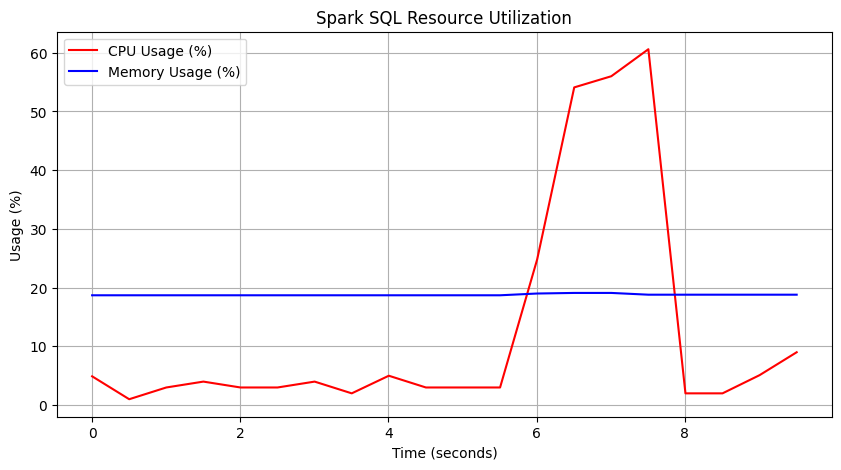

In [ ]:
monitor_thread = threading.Thread(target=monitor_resources, args=(10, 0.5))
monitor_thread.start()

train_df.createOrReplaceTempView("hospital_data")
sql_avg_cost = spark.sql("""
    SELECT time_in_hospital, AVG(num_medications) AS avg_medications
    FROM hospital_data
    GROUP BY time_in_hospital
""")
sql_avg_cost.show()

monitor_thread.join()
timestamps, cpu_usage, memory_usage = monitor_resources(10, 0.5)
plot_metrics(timestamps, cpu_usage, memory_usage, "Spark SQL Resource Utilization")


+----------------+-------------------+
|time_in_hospital|avg_num_medications|
+----------------+-------------------+
|            13.0|               28.0|
|            12.0|               18.0|
|             9.0|               17.0|
|             3.0|               16.0|
|             7.0|               11.0|
|            10.0|               31.0|
|             1.0|                2.0|
|             5.0|               12.0|
|             2.0|               13.0|
|            12.0|               13.0|
|             3.0|               11.0|
|             5.0|               23.0|
|             6.0|               23.0|
|             3.0|               18.0|
|             2.0|               19.0|
|             2.0|               12.0|
|            11.0|               19.0|
|             3.0|               18.0|
|             6.0|               18.0|
|             2.0|               11.0|
+----------------+-------------------+
only showing top 20 rows

+----------------+------------------+


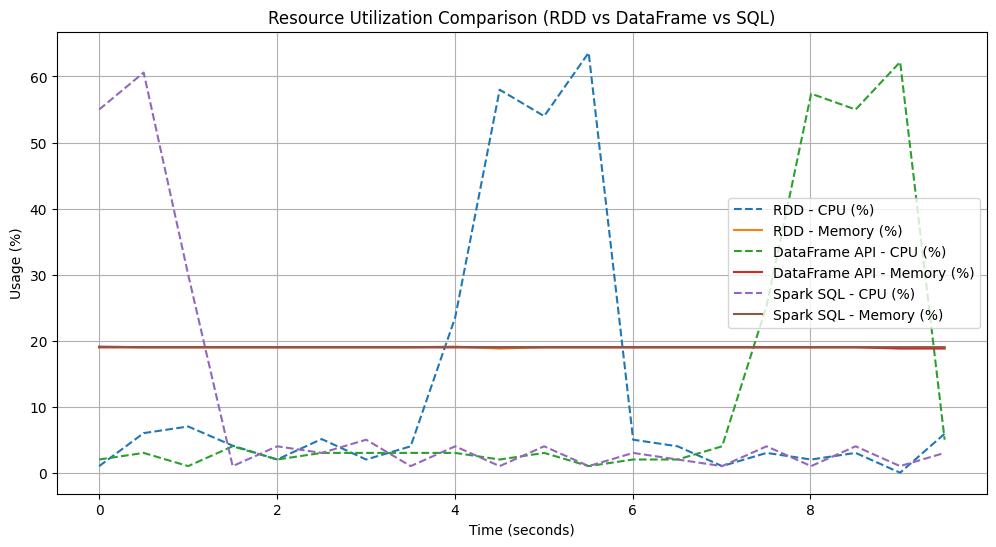

In [ ]:
import threading
import time
import psutil
import matplotlib.pyplot as plt
from pyspark.sql import Row
from pyspark.sql.functions import avg

# Monitor resources function (already implemented)
def monitor_resources(duration=10, interval=0.5):
    timestamps, cpu_usage, memory_usage = [], [], []
    start_time = time.time()

    while time.time() - start_time < duration:
        timestamps.append(time.time() - start_time)
        cpu_usage.append(psutil.cpu_percent())
        memory_usage.append(psutil.virtual_memory().percent)
        time.sleep(interval)

    return timestamps, cpu_usage, memory_usage

# Plot metrics function (already implemented)
def plot_metrics(timestamps, cpu_usage, memory_usage, title):
    plt.plot(timestamps, cpu_usage, label=f"{title} - CPU (%)", linestyle='--')
    plt.plot(timestamps, memory_usage, label=f"{title} - Memory (%)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Usage (%)")
    plt.legend()
    plt.grid()

# ------------------------------
# RDD-based approach
# ------------------------------
monitor_thread = threading.Thread(target=monitor_resources, args=(10, 0.5))
monitor_thread.start()

rdd_avg_cost = train_df.select("time_in_hospital", "num_medications").rdd
rdd_avg_cost_df = rdd_avg_cost.map(lambda x: Row(time_in_hospital=x[0], avg_num_medications=x[1])).toDF()
rdd_avg_cost_df.show()

monitor_thread.join()
timestamps_rdd, cpu_rdd, mem_rdd = monitor_resources(10, 0.5)

# ------------------------------
# DataFrame API approach
# ------------------------------
monitor_thread = threading.Thread(target=monitor_resources, args=(10, 0.5))
monitor_thread.start()

df_avg_cost = train_df.groupBy("time_in_hospital").agg(avg("num_medications").alias("avg_medications"))
df_avg_cost.show()

monitor_thread.join()
timestamps_df, cpu_df, mem_df = monitor_resources(10, 0.5)

# ------------------------------
# Spark SQL approach
# ------------------------------
monitor_thread = threading.Thread(target=monitor_resources, args=(10, 0.5))
monitor_thread.start()

train_df.createOrReplaceTempView("hospital_data")
sql_avg_cost = spark.sql("""
    SELECT time_in_hospital, AVG(num_medications) AS avg_medications
    FROM hospital_data
    GROUP BY time_in_hospital
""")
sql_avg_cost.show()

monitor_thread.join()
timestamps_sql, cpu_sql, mem_sql = monitor_resources(10, 0.5)

# ------------------------------
# Plot all three in a single graph
# ------------------------------
plt.figure(figsize=(12, 6))

plot_metrics(timestamps_rdd, cpu_rdd, mem_rdd, "RDD")
plot_metrics(timestamps_df, cpu_df, mem_df, "DataFrame API")
plot_metrics(timestamps_sql, cpu_sql, mem_sql, "Spark SQL")

plt.title("Resource Utilization Comparison (RDD vs DataFrame vs SQL)")
plt.show()
